In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy.stats import qmc
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
from explainabilityModels import make_gradcam_heatmap as GradCam

2023-02-14 12:40:09.636443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 12:40:09.959974: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-14 12:40:11.225817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-14 12:40:11.226068: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
N = 1000
n_exp = 7
n_pts = 2**7
size = 64
labels = np.random.randint(1, size = N)
imgs = np.zeros((size, size, N))




In [3]:
#fill array with corresponding images
from tqdm import tqdm
for i in tqdm(range(N)):
    if labels[i] == 0:
        x = generator.generate_quasi_img()
    elif labels[i] == 1:
        x = generator.generate_pseudo_img()
    elif labels[i] == 2:
        x = generator.generate_2d_power(pow = 1.5)
    elif labels[i] == 3:
        x = generator.generate_2d_normal()
    imgs[:,:,i] = x

100%|██████████| 1000/1000 [00:00<00:00, 1061.24it/s]


2023-02-14 12:40:20.770588: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-14 12:40:20.770635: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ancoramsi2): /proc/driver/nvidia/version does not exist
2023-02-14 12:40:20.771662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 37ms/step


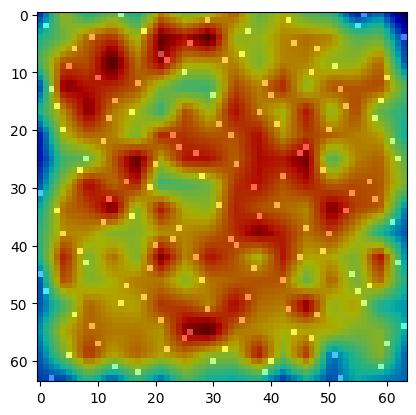

In [4]:
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils.scores import CategoricalScore
model = tf.keras.models.load_model("models/model30_distro")

scorecam = Scorecam(model)
img = imgs[:,:,0]
img = np.expand_dims(img, -1)
label = labels[0]
map = scorecam(CategoricalScore(label), img).squeeze()
plt.imshow(img, cmap = 'gray')
plt.imshow(map, cmap = 'jet', alpha = 0.7)

In [5]:
import ipywidgets as widgets

method_picker = widgets.Dropdown(
    options=[('Grad-CAM', 0), ('Grad-CAM++', 1), ('ScoreCAM', 2), ('LayerCAM', 3)],
    value=0,
    description='Method:',
)

#pick what you want to see
display(method_picker)



Dropdown(description='Method:', options=(('Grad-CAM', 0), ('Grad-CAM++', 1), ('ScoreCAM', 2), ('LayerCAM', 3))…

In [6]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.layercam import Layercam
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
model = tf.keras.models.load_model("models/model30_distro/")
#model.layers[-1].activation = None
cat = CategoricalScore(0)
mod = ReplaceToLinear()
if method_picker.value == 0:
    method = Gradcam(model, model_modifier = mod, clone = True)
elif method_picker.value == 1:
    method = GradcamPlusPlus(model, model_modifier = mod, clone = True)

elif method_picker.value == 2:
    method = Scorecam(model)

elif method_picker.value == 3:
    method = Layercam(model, model_modifier = mod, clone = True)


method



In [7]:
#make gradcam heatmap for every image and normalise
from tqdm import tqdm
heatmaps = np.zeros_like(imgs)

for img in range(N):
    heatmaps[:,:,img] = method(cat, np.expand_dims(imgs[:,:,img],-1)).squeeze()
    #heatmaps[:,:,img] = minmax_scale(heatmaps[:,:,img])



In [8]:
#get segmentation for every image
region_imgs = np.zeros_like(imgs, dtype=np.int64)

for img in range(N):
    region_imgs[:,:,img] = measure.label(imgs[:,:,img])

In [9]:
#find number of blobs in all images
num_blobs_array = []
for img in range(N):
    num_blobs_array.append(np.unique(region_imgs[:,:,img]).shape[0] - 1)

num_blobs = sum(num_blobs_array)
num_blobs

125970

In [10]:
num_blobs//imgs.shape[-1]

125

In [11]:
#generate interpretability scores for each blob; score is the sum of intensities of heatmap in the region
#plus get the highest score for every image
scores = np.zeros(num_blobs)
i = 0
highscores = []
for img in range(N):
    img_highscore = 0
    for region in np.unique(region_imgs[:,:,img]):   
        if region != 0:
            x = np.copy(region_imgs[:,:,img])
            x[x != region] = 0
            x[x == region] = 1
            img_score = heatmaps[:,:,img] * x
            scores[i] = np.mean(img_score[img_score!=0])
            if scores[i] > img_highscore:
                img_highscore = scores[i]
            i += 1
    highscores.append(img_highscore)
        

/home/wph/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wph/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
scores = np.nan_to_num(scores, nan=0)


In [13]:
highscores = np.asarray(highscores)
ind = np.where(np.in1d(scores, highscores))[0]
ind.shape

(14432,)

In [13]:
blob_areas = []
blob_eccentricities = []
blob_eq_diameter = []
blob_bboxs = []
blob_major_axes = []
blob_minor_axes = []
blob_extents = []
#blob_max_intensities = []
#blob_min_intensities = []
#blob_mean_intensities = []
blob_solidities = []
for img in range(N):
    areas = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['area'])).to_numpy().squeeze()
    eccentricities = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['eccentricity'])).to_numpy().squeeze()
    eq_diameter = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['equivalent_diameter_area'])).to_numpy().squeeze()
    bbox = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['area_bbox'])).to_numpy().squeeze()
    major_axis = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['axis_major_length'])).to_numpy().squeeze()
    minor_axis = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['axis_minor_length'])).to_numpy().squeeze()
    extent = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['extent'])).to_numpy().squeeze()
    #intensity_max = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['intensity_max'])).to_numpy().squeeze()
    #intensity_mean = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['intensity_mean'])).to_numpy().squeeze()
    #intensity_min = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['intensity_min'])).to_numpy().squeeze()
    solidity = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['solidity'])).to_numpy().squeeze()
    blob_areas += areas.tolist()
    blob_eccentricities += eccentricities.tolist()
    blob_eq_diameter += eq_diameter.tolist()
    blob_bboxs += bbox.tolist()
    blob_major_axes += major_axis.tolist()
    blob_minor_axes += minor_axis.tolist()
    blob_extents += extent.tolist()
    #blob_max_intensities += intensity_max.tolist()
    #blob_min_intensities += intensity_min.tolist()
    #blob_mean_intensities += intensity_min.tolist()
    blob_solidities += solidity.tolist()


blob_areas = np.asarray(blob_areas)
blob_eccentricities = np.asarray(blob_eccentricities)
blob_eq_diameter = np.asarray(blob_eq_diameter)
blob_bboxs = np.asarray(blob_bboxs)
blob_major_axes = np.asarray(blob_major_axes)
blob_minor_axes = np.asarray(blob_minor_axes)
blob_extents = np.asarray(blob_extents)
#blob_max_intensities = np.asarray(blob_max_intensities)
#blob_min_intensities = np.asarray(blob_min_intensities)
#blob_mean_intensities = np.asarray(blob_mean_intensities)
blob_solidities = np.asarray(blob_solidities)

blob_areas.shape

(125970,)

In [14]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.vstack((blob_eccentricities, blob_areas, blob_eq_diameter, blob_bboxs, blob_extents, blob_major_axes, blob_minor_axes, blob_solidities))
X = np.transpose(X)
y = scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)





In [16]:
#build regression tree
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=2)
regressor = regressor.fit(X_train, y_train)

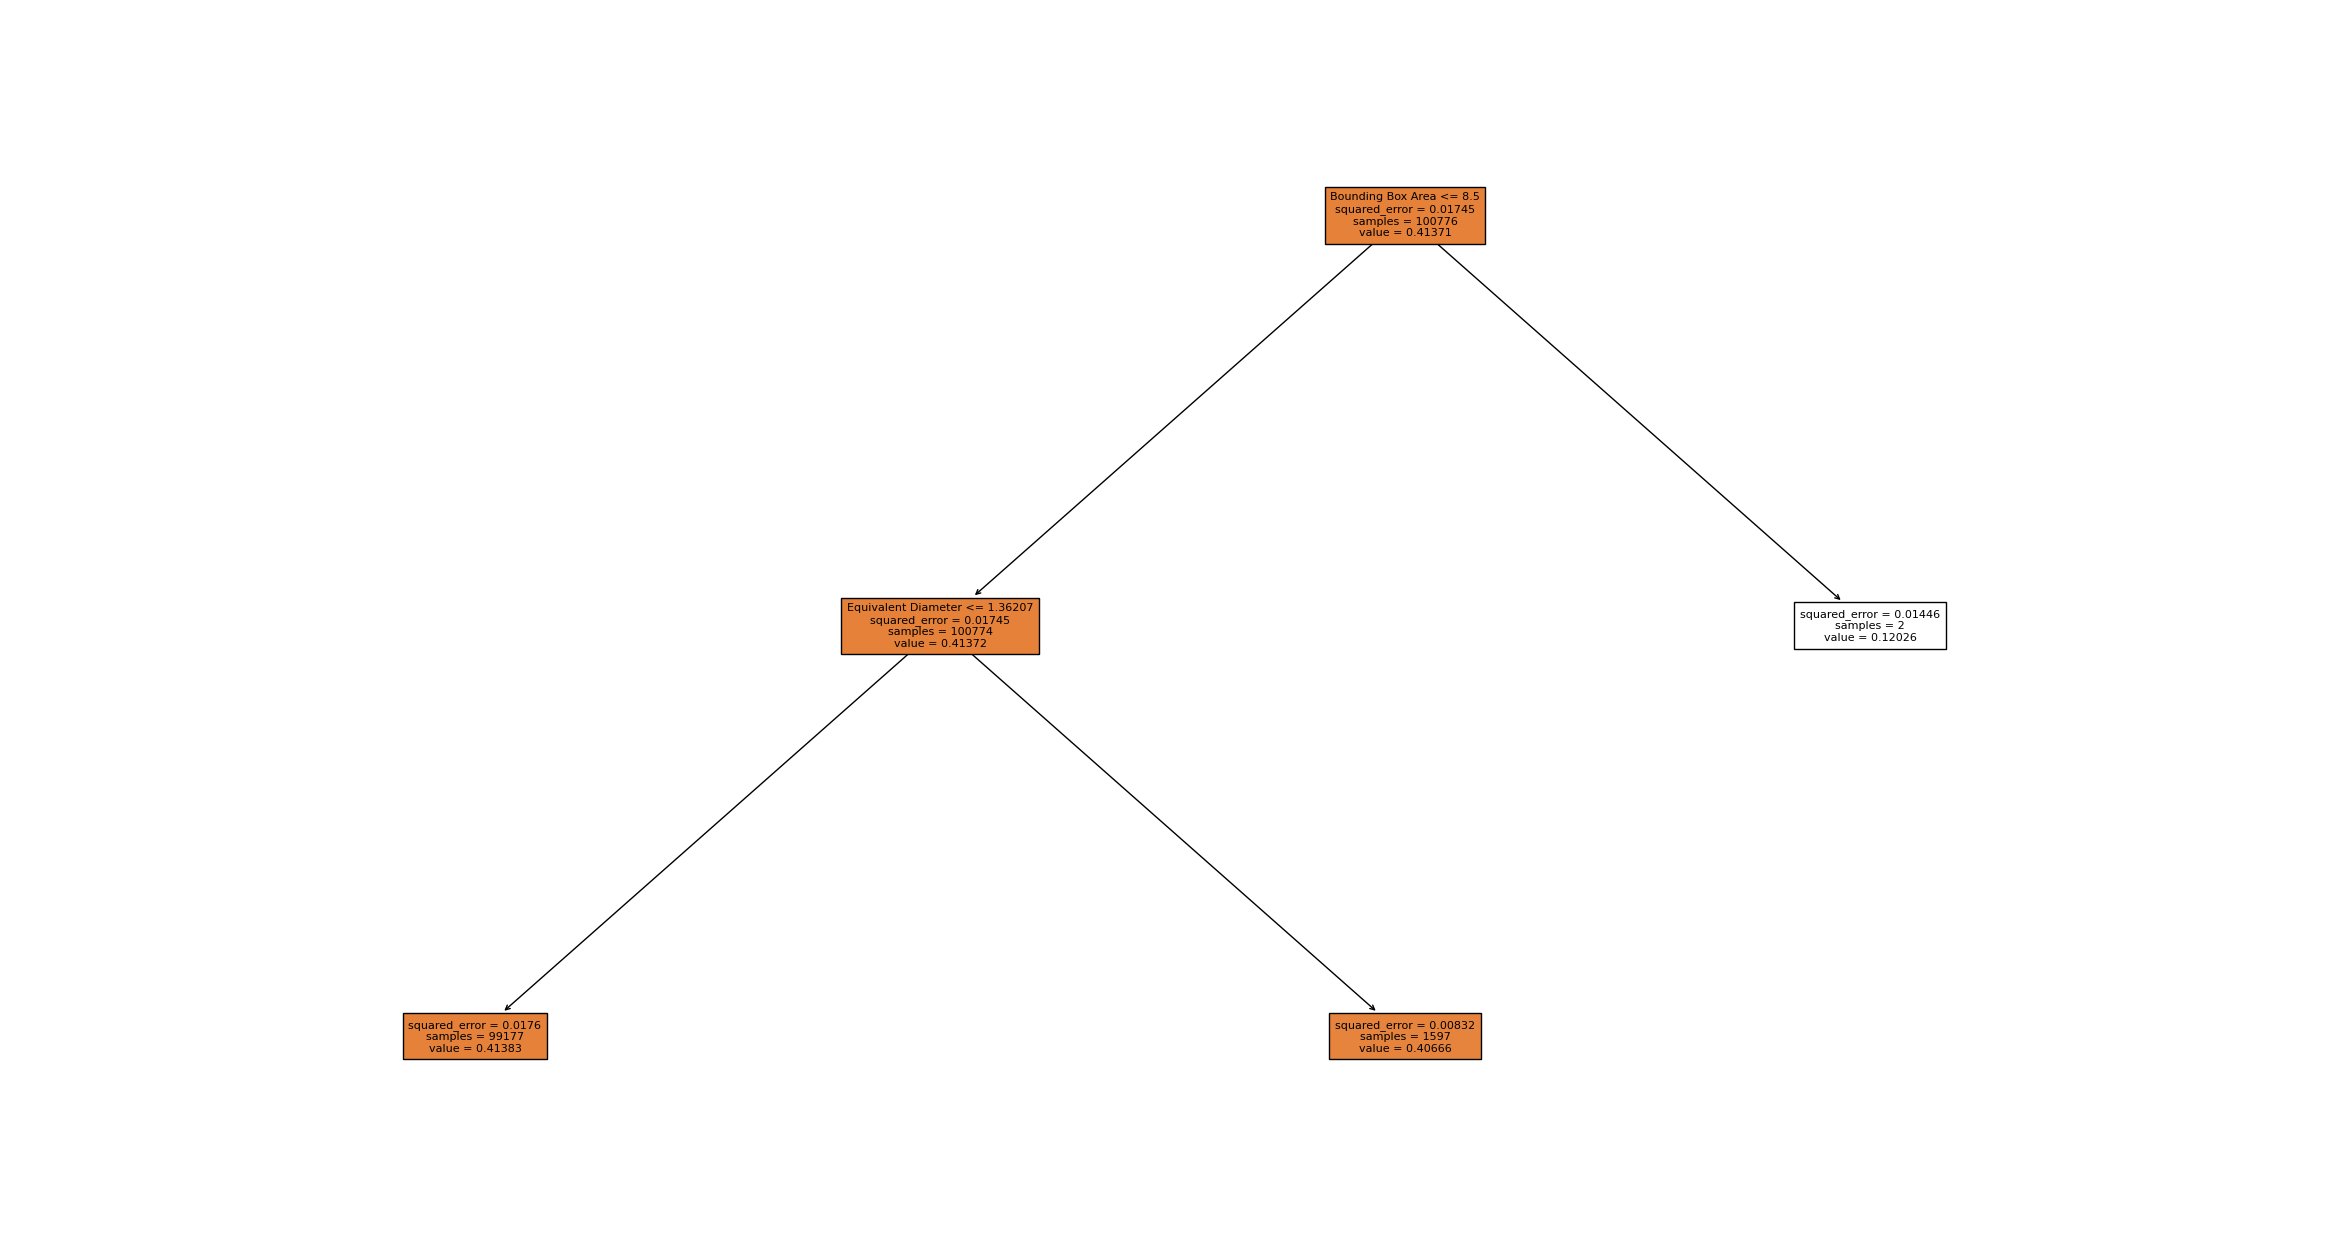

In [17]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30,16))
plot_tree(regressor, max_depth=2, feature_names=['Eccentricity', 'Area', 'Equivalent Diameter', 'Bounding Box Area', 'Extent', 'Major Axis', 'Minor Axis', 'Solidity'], filled=True, fontsize=8, precision=5)
plt.show()


In [15]:
from sklearn.ensemble import RandomForestRegressor

feature_names = ['Eccentricity', 'Area', 'Equivalent Diameter', 'Bounding Box Area', 'Extent', 'Major Axis', 'Minor Axis', 'Solidity']
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [16]:
forest.score(X_test, y_test)

0.0003029102930198757

In [19]:
from sklearn.inspection import permutation_importance

result = permutation_importance(forest, X_test, y_test, n_repeats = 10, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

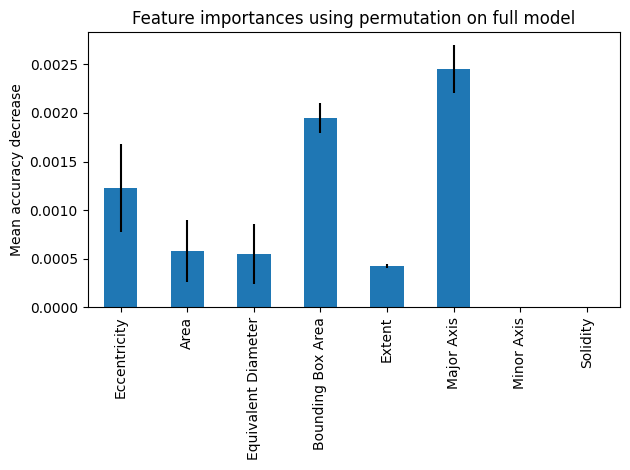

In [20]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()